# Integrated Calibration Index (ICI)

## Theoretical Background

Integrated Calibration Index (ICI) is essentially the same as expected calibration error (ECE) in terms of the idea. They both try to measure the average deviation of the predicted probabilities from the true probabilities. However, ECE is calculated by grouping the samples into bins and then calculating the weighted average of the deviation of the mean predicted probabilities from the empirical accuracy. ICI, on the other hand, is calculated by fitting a smooth curve using the samples itself and therefore doesn't require binning. However, the choice of the curve fitting method can affect the result and is arbitrary. The most common choice is locally estimated scatterplot smoothing (LOESS) (Cleveland, 1979). People also use other methods such as polynomial fitting and spline fitting. Interestingly, not many people have looked into using COX regression results to calculate ICI, which is implemented in calzone. Notice that the Cox-ICI can be way off from the truth if the logistic regression does not result in a good fit.

The formula for ICI is:

$$
\text{ICI} = \int_0^1 |\mathbb{S}(p)-p| \, dF_{\hat{P}}(p)
$$

where $\mathbb{S}(p)$ is the fitted function and $F_{\hat{P}}(p)$ is the cumulative distribution function of the empirical probabilities. In the actual implementation, we calculate

$$
\text{ICI} = \frac{1}{N} \sum_{i=1}^N  |\mathbb{S}(p_i)-p_i|
$$

where $p_i$ is the predicted probability of the $i$-th sample.

## Pros of ICI

The main advantage of ICI is that it skips the need for binning while still giving an easily interpretable metric. It is essentially the same as ECE and can be interpreted as the average deviation from the true probability. ICI can capture any type of miscalibration if the calibration curve is well-described by the fitting method.

## Cons of ICI

The main disadvantage of ICI is the need for a fitting method. Locally estimated scatterplot smoothing (LOESS) is a non-parametric regression method that fits a smooth line through the data. It is the most common method used in ICI. However, it still requires hyperparameters like the span (window width) which could affect the fitting result and ICI greatly.

## Calculating LOESS ICI and COX ICI using calzone

To calculate LOESS ICI and COX ICI using calzone, we can call the function directly

In [1]:
from calzone.utils import reliability_diagram,data_loader
from calzone.metrics import cox_regression_analysis,lowess_regression_analysis,cal_ICI_cox

### loading the data
wellcal_dataloader = data_loader(data_path="../../../example_data/simulated_welldata.csv")

### calculating cox ICI
cox_slope, cox_intercept,cox_slope_ci,cox_intercept_ci = cox_regression_analysis(wellcal_dataloader.labels, wellcal_dataloader.probs,class_to_calculate=1,print_results=False)
cox_ici = cal_ICI_cox(cox_slope, cox_intercept, wellcal_dataloader.probs, class_to_calculate=1)

### calculating loess ICI
loess_ici, lowess_fit_p, lowess_fit_p_correct = lowess_regression_analysis(wellcal_dataloader.labels, wellcal_dataloader.probs, class_to_calculate=1, span=0.5, delta=0.001, it=0)

print(f"Cox ICI: {cox_ici}")
print(f"Loess ICI: {loess_ici}")


Cox ICI: 0.005610391483826338
Loess ICI: 0.00558856942568957


Alternatively, we can use the CalibrationMetrics class to compute the COX and Loess ICI

In [2]:
from calzone.metrics import CalibrationMetrics
calmetrics = CalibrationMetrics()
calmetrics.calculate_metrics(wellcal_dataloader.labels, wellcal_dataloader.probs, metrics=['COX','Loess'])

{'COX coef': 0.9942499557748269,
 'COX intercept': -0.04497652296600376,
 'COX coef lowerci': 0.9372902801721911,
 'COX coef upperci': 1.0512096313774626,
 'COX intercept lowerci': -0.12348577118577644,
 'COX intercept upperci': 0.03353272525376893,
 'COX ICI': 0.005610391483826338,
 'Loess ICI': 0.00558856942568957}

## Visualization of the fitted curve

We can also plot the loess curve and the COX curve.

In [3]:
### We will use linear miscalibrated data to demostrate the plot. Notice that the COX should capture the miscalibration perfectly in the example case.
miscal_dataloader = data_loader(data_path="../../../example_data/simulated_misdata.csv")

### calculating cox ICI
cox_slope, cox_intercept,cox_slope_ci,cox_intercept_ci = cox_regression_analysis(miscal_dataloader.labels, miscal_dataloader.probs,class_to_calculate=1,print_results=False)
cox_ici = cal_ICI_cox(cox_slope, cox_intercept, wellcal_dataloader.probs, class_to_calculate=1)

### calculating loess ICI
loess_ici, lowess_fit_p, lowess_fit_p_correct = lowess_regression_analysis(miscal_dataloader.labels, miscal_dataloader.probs, class_to_calculate=1)

### We also try a different span
loess_ici2, lowess_fit_p2, lowess_fit_p2_correct = lowess_regression_analysis(miscal_dataloader.labels, miscal_dataloader.probs, class_to_calculate=1, span=0.3, delta=0.001, it=0)

print("Cox ICI: ", cox_ici)
print("Loess ICI (span = 0.5): ", loess_ici)
print("Loess ICI (span = 0.3): ", loess_ici2)

Cox ICI:  0.0984122810555748
Loess ICI (span = 0.5):  0.07356445428053172
Loess ICI (span = 0.3):  0.07692218401743334


Text(0.5, 1.0, 'Calibration Curve')

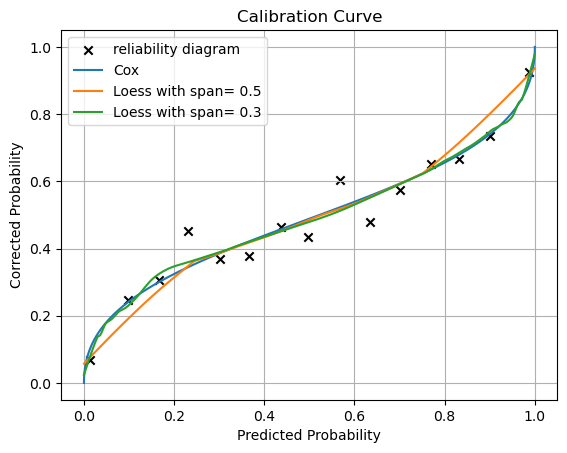

In [4]:
### ploting the curve
from calzone.metrics import logit_func
import matplotlib.pyplot as plt
from calzone.utils import reliability_diagram
from calzone.vis import plot_reliability_diagram
import numpy as np
cox_func= logit_func(coef=cox_slope, intercept=cox_intercept)
proba_class1 = np.sort(np.clip(miscal_dataloader.probs[:,1],1e-10,1-1e-10))
cox_p_correct=cox_func(proba_class1)
reliability,confindence,bin_edges,bin_counts = reliability_diagram(miscal_dataloader.labels, miscal_dataloader.probs, num_bins=15,class_to_plot=1) 
plt.scatter(confindence,reliability, label="reliability diagram", marker="x",color='k')
#ig = plot_reliability_diagram(reliability, confindence, bin_counts)
#plt.close()
#print(fig)
plt.plot(proba_class1, cox_p_correct, label="Cox")
plt.plot(lowess_fit_p, lowess_fit_p_correct, label="Loess with span= 0.5")
plt.plot(lowess_fit_p2, lowess_fit_p2_correct, label="Loess with span= 0.3")
plt.xlabel("Predicted Probability")
plt.ylabel("Corrected Probability")
plt.legend()
plt.grid()
plt.title("Calibration Curve")

## Reference

Cleveland, W.S. (1979) “Robust Locally Weighted Regression and Smoothing Scatterplots”. Journal of the American Statistical Association 74 (368): 829-836.

Austin, P. C., & Steyerberg, E. W. (2019). The Integrated Calibration Index (ICI) and related metrics for quantifying the calibration of logistic regression models. Statistics in Medicine, 38(21), 4051–4065. https://doi.org/10.1002/sim.8281

Huang, Y., Li, W., Macheret, F., Gabriel, R. A., & Ohno-Machado, L. (2020). A tutorial on calibration measurements and calibration models for clinical prediction models. Journal of the American Medical Informatics Association, 27(4), 621–633. https://doi.org/10.1093/jamia/ocz228

